In [1]:
import os
import random
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
def grayscale_conversion():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    
    no_of_images = []
    for folder in folders:
        files = [f for f in os.listdir(f"../Cropped/{folder}") if os.path.isfile(os.path.join(f"../Cropped/{folder}", f))]
        no_of_images.append(len(files))

    collect = {}
    for folder, count in zip(folders, no_of_images):
        all_files = os.listdir(f"../Cropped/{folder}")
        collect[folder] = all_files
        
    
    grayscaled_images = {}
    for folder, images in collect.items():
        combine = []
        for img in images:
            path = f"../Cropped/{folder}/{img}"
            loaded_image = cv.imread(path)
            combine.append(cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY))
        grayscaled_images[folder] = combine
    
    return grayscaled_images 

In [3]:
def split_dataset():
    grayscaled_images = grayscale_conversion()
    
    training_set = {}
    testing_set = {}
    for folder in grayscaled_images:
        perce_80 = int(len(grayscaled_images[folder]) * 0.8)
        training_set[folder] = random.sample(grayscaled_images[folder], perce_80)
 
    for folder, images in grayscaled_images.items():
        combine = []
        for img in images:
            if not np.all(np.equal(img, training_set[folder]), axis=1).any():
                combine.append(img)             
        testing_set[folder] = combine
    
    return training_set, testing_set

In [4]:
def train_test_split():
    training_set, testing_set = split_dataset()
    
    X_train, y_train, X_test, y_test = ([] for i in range(4))
    
    count = 0
    for training_folder in training_set:
        for training_image in training_set[training_folder]:
            X_train.append(training_image.ravel())
            y_train.append(count)
        count += 1
    
    count = 0
    for testing_folder in testing_set:
        for testing_image in testing_set[testing_folder]:
            X_test.append(testing_image.ravel())
            y_test.append(count)
        count += 1
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test

In [5]:
def standardized_dataset():
    a, y_train, b, y_test = train_test_split()
     
    standard = StandardScaler()
    X_train = standard.fit_transform(a)
    X_test = standard.transform(b)
        
    return X_train, y_train, X_test, y_test

In [9]:
def knn_classifier():
    X_train, y_train, X_test, y_test = standardized_dataset()
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    no_neighbors = [1, 3, 5, 7, 10, 20]

    testing_standard_fold_results = []
    training_standard_fold_results = []
    testing_stratified_fold_results = []
    training_stratified_fold_results = []

    for k in no_neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        
        train_kf_scores = []
        for train_index, test_index in kf.split(X_train, y_train):
            X_tr, X_te = X_train[train_index], X_train[test_index]
            y_tr, y_te = y_train[train_index], y_train[test_index]
            
            knn.fit(X_tr, y_tr)
            y_pred = knn.predict(X_te)
            train_kf_scores.append(1 - accuracy_score(y_te, y_pred))

        training_standard_fold_results.append(np.mean(train_kf_scores))
        
        test_kf_scores = []
        for train_index, test_index in kf.split(X_test, y_test):
            X_tr, X_te = X_test[train_index], X_test[test_index]
            y_tr, y_te = y_test[train_index], y_test[test_index]
            
            knn.fit(X_tr, y_tr)
            y_pred = knn.predict(X_te)
            test_kf_scores.append(1 - accuracy_score(y_te, y_pred))
        
        testing_standard_fold_results.append(np.mean(test_kf_scores))
        
        
        knn = KNeighborsClassifier(n_neighbors=k)

        train_skf_scores = []
        for train_index, test_index in skf.split(X_train, y_train):
            X_tr, X_te = X_train[train_index], X_train[test_index]
            y_tr, y_te = y_train[train_index], y_train[test_index]
            
            knn.fit(X_tr, y_tr)
            y_pred = knn.predict(X_te)
            train_skf_scores.append(1 - accuracy_score(y_te, y_pred))
        
        training_stratified_fold_results.append(np.mean(train_skf_scores))
        
        test_skf_scores = []
        for train_index, test_index in skf.split(X_test, y_test):
            X_tr, X_te = X_test[train_index], X_test[test_index]
            y_tr, y_te = y_test[train_index], y_test[test_index]
            
            knn.fit(X_tr, y_tr)
            y_pred = knn.predict(X_te)
            test_skf_scores.append(1 - accuracy_score(y_te, y_pred))
        
        testing_stratified_fold_results.append(np.mean(test_skf_scores))
    
    return training_standard_fold_results, testing_standard_fold_results, training_stratified_fold_results, testing_stratified_fold_results

Result for training standard 5-fold with k = 1: 53.74%
Result for training standard 5-fold with k = 3: 55.10%
Result for training standard 5-fold with k = 5: 54.31%
Result for training standard 5-fold with k = 7: 53.17%
Result for training standard 5-fold with k = 10: 54.32%
Result for training standard 5-fold with k = 20: 54.70%


Result for validation standard 5-fold with k = 1: 55.27%
Result for validation standard 5-fold with k = 3: 57.69%
Result for validation standard 5-fold with k = 5: 59.20%
Result for validation standard 5-fold with k = 7: 58.40%
Result for validation standard 5-fold with k = 10: 58.35%
Result for validation standard 5-fold with k = 20: 54.47%


Result for training stratified 5-fold with k = 1: 54.32%
Result for training stratified 5-fold with k = 3: 53.56%
Result for training stratified 5-fold with k = 5: 54.15%
Result for training stratified 5-fold with k = 7: 51.83%
Result for training stratified 5-fold with k = 10: 52.41%
Result for training stratified 5-f

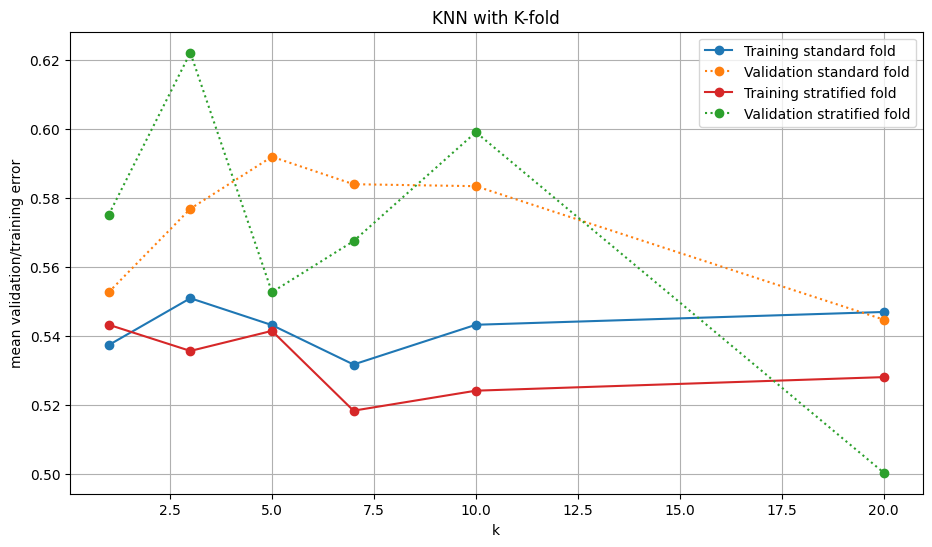

In [10]:
def plot_knn():
    no_neighbors = [1, 3, 5, 7, 10, 20]
    training_standard_fold_results, testing_standard_fold_results, training_stratified_fold_results, testing_stratified_fold_results = knn_classifier()
    
    for i, j in zip(no_neighbors, training_standard_fold_results):
        j = j * 100
        print(f"Result for training standard 5-fold with k = {i}: {j:0.2f}%")
    print("\n")
    
    for i, j in zip(no_neighbors, testing_standard_fold_results):
        j = j * 100
        print(f"Result for validation standard 5-fold with k = {i}: {j:0.2f}%")
    print("\n")
    
    for i, j in zip(no_neighbors, training_stratified_fold_results):
        j = j * 100
        print(f"Result for training stratified 5-fold with k = {i}: {j:0.2f}%")
    print("\n")
    
    for i, j in zip(no_neighbors, testing_stratified_fold_results):
        j = j * 100
        print(f"Result for validation stratified 5-fold with k = {i}: {j:0.2f}%")

    plt.figure(figsize=(11, 6))
    plt.plot(no_neighbors, training_standard_fold_results, marker="o", color='tab:blue')
    plt.plot(no_neighbors, testing_standard_fold_results, linestyle=":", marker="o", color='tab:orange')
    plt.plot(no_neighbors, training_stratified_fold_results, marker="o", color='tab:red')
    plt.plot(no_neighbors, testing_stratified_fold_results, linestyle=":", marker="o", color='tab:green')
    plt.title("KNN with K-fold")
    plt.xlabel("k")
    plt.ylabel("mean validation/training error")
    plt.grid(True)
    plt.legend(("Training standard fold", "Validation standard fold", "Training stratified fold", "Validation stratified fold") 
               , loc = 1)
    plt.show()
        
plot_knn()

For standard training k = 1, for standard testing k = 1, for stratified training k = 3 and for stratified testing k = 1 have a value with the smallest k mean error.

For k = 1 it is more complex as there is less error. However, when k = 20, 10 and 3, the model is becoming less complex.

For k = 1 the model is overfitting since there is minimum error. However, for k = 20, 10 and 3 the model is generalizting or becoming less overfitting. 

In [11]:
def validation_stratified_knn():
    X_train, y_train, X_test, y_test = train_test_split()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    k = 1
    knn = KNeighborsClassifier(k)

    scores = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_te = X_train[train_index], X_train[test_index]
        y_tr, y_te = y_train[train_index], y_train[test_index]

        knn.fit(X_tr, y_tr)
        scores.append(1 - knn.score(X_test, y_test))

    result = np.mean(scores)
    percentage = result * 100
    print(f"Testing error: {percentage:0.2f}%")

validation_stratified_knn()

Testing error: 50.30%


In [12]:
def naive_bayes_classifier():
    X_train, y_train, X_test, y_test = train_test_split()
    gnb = GaussianNB()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    scores = []
#     confu_matrix = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_te = X_train[train_index], X_train[test_index]
        y_tr, y_te = y_train[train_index], y_train[test_index]
        
        gnb.fit(X_tr, y_tr)
#         y_pred = gnb.predict(X_te)

#         confu_matrix.append(y_pred)
        scores.append(1 - gnb.score(X_te, y_te))
    
    result = np.mean(scores)
    percentage = result * 100
    print(f"Cross validation result: {percentage:0.2f}%")
    
    score = 1 - gnb.score(X_test, y_test)
    print(f"Testing result: {score * 100:0.2f}%")
    
    y_pred = gnb.predict(X_test)
    
    f_measure = f1_score(y_test, y_pred, average='macro')
    print(f"f-measure result: {f_measure * 100:0.2f}%")
    
    return y_pred, y_test

Cross validation result: 42.20%
Testing result: 46.97%
f-measure result: 52.90%


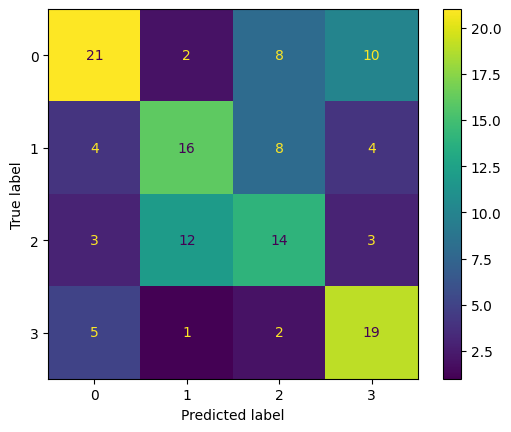

In [13]:
def naive_bayes_confusion_matrix():
    y_pred, y_test = naive_bayes_classifier()
    
    cm = confusion_matrix(y_pred, y_test)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    
naive_bayes_confusion_matrix()

In [14]:
def neural_network_classifier():
    X_train, y_train, X_test, y_test = train_test_split()
    clf = MLPClassifier(hidden_layer_sizes=(10, 10, 10))
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    scores = []
    confu_matrix = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_te = X_train[train_index], X_train[test_index]
        y_tr, y_te = y_train[train_index], y_train[test_index]
    
        clf.fit(X_tr, y_tr)
#         y_pred = clf.predict(X_te)
        
#         confu_matrix.extend(y_pred)
        scores.append(1 - clf.score(X_te, y_te))
        
    result = np.mean(scores)
    percentage = result * 100
    print(f"Cross validation result: {percentage:0.2f}%")
    
    score = 1 - clf.score(X_test, y_test)
    print(f"Testing result: {score * 100:0.2f}%")
    
    y_pred = clf.predict(X_test)
    
    f_measure = f1_score(y_test, y_pred, average='macro')
    print(f"f-measure result: {f_measure * 100:0.2f}%")
    
    return y_pred, y_test

Cross validation result: 73.02%
Testing result: 72.73%
f-measure result: 10.71%


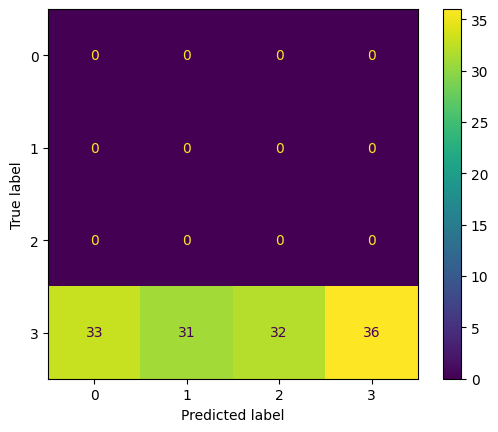

In [15]:
def neural_network_confusion_matrix():
    y_pred, y_test = neural_network_classifier()
    
    cm = confusion_matrix(y_pred, y_test)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    
neural_network_confusion_matrix()

In [16]:
def adaboost_classifier():
    X_train, y_train, X_test, y_test = train_test_split()
    ada = AdaBoostClassifier()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = []
    confu_matrix = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_te = X_train[train_index], X_train[test_index]
        y_tr, y_te = y_train[train_index], y_train[test_index]
    
        ada.fit(X_tr, y_tr)
#         y_pred = ada.predict(X_te)
        
#         confu_matrix.extend(y_pred)
        scores.append(1 - ada.score(X_te, y_te))
        
    result = np.mean(scores)
    percentage = result * 100
    print(f"Cross validation result: {percentage:0.2f}%")
    
    score = 1 - ada.score(X_test, y_test)
    print(f"Testing result: {score * 100:0.2f}%")

    y_pred = ada.predict(X_test)
    
    f_measure = f1_score(y_test, y_pred, average='macro')
    print(f"f-measure result: {f_measure * 100:0.2f}%")
    
    return y_pred, y_test

Cross validation result: 51.44%
Testing result: 56.06%
f-measure result: 42.61%


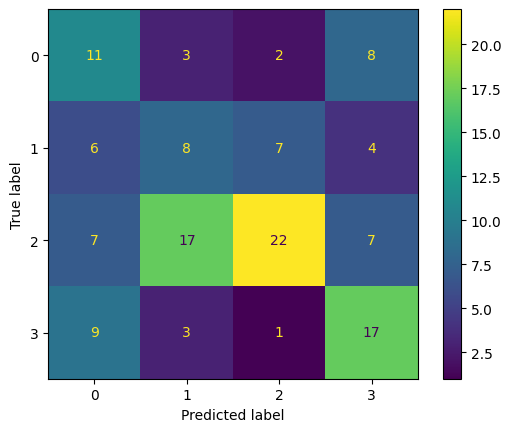

In [17]:
def ada_boost_confusion_matrix():
    y_pred, y_test = adaboost_classifier()
    
    cm = confusion_matrix(y_pred, y_test)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    
ada_boost_confusion_matrix()

Based on the cofusion matrix Navie Bayes Classifier out performs the others. Because it has more diagonal value 78, which is more than 73 and 58 from Neural Network and Adaboost Classifiers respectively.

Based on the mean validation accuracies Adaboost Classifier is the best method compared to the others. Because it has 51.82% , which is more than 45.66% and 43.16% from Neural Network and Naive Bayes Classifiers respectively.

Based on the test set accuracies Adaboost Classifier is the best method compared to the others. Because it has 56.06%, which is more than 44.70% and 40.91% from Neural Network and Navie Bayes Classifiers respectively.

Based on the test set for the F-measure score Naive Bayes Classifier is the best method compared to the others. Because it has 57.33%, which is more than 55.65% and 43.45% from Neural Network and Adaboost Classifiers respectively.

# Source for Confusion matrix:
https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_display_object_visualization.html#sphx-glr-auto-examples-miscellaneous-plot-display-object-visualization-py
